# Prepare for persistent storage of results

In [1]:
import os
import shutil

varinfo = {"root_uri": "/tmp/myresults"}

def prepare_results(clean=True):
    if clean:
        shutil.rmtree(varinfo["root_uri"], ignore_errors=True)
    os.makedirs(varinfo["root_uri"], exist_ok=True)

# Bindings for task schedulers

In [2]:
schedulers = {}

In [3]:
def sequential_execution(taskgraph, varinfo):
    # runs in a single thread
    from esrftaskgraph import load_graph

    runtime_taskgraph = load_graph(taskgraph)
    runtime_taskgraph.run(varinfo=varinfo)
            
schedulers[None] = sequential_execution

In [4]:
def multithreading_scheduler(taskgraph, varinfo):
    # tasks are distributed over threads
    import esrf2paradag

    esrf2paradag.job(taskgraph, varinfo=varinfo)

schedulers["multithreading"] = multithreading_scheduler

In [5]:
def multiprocessing_scheduler(taskgraph, varinfo):
    # tasks are distributed over processes
    import esrf2multiprocessing

    esrf2multiprocessing.job(taskgraph, varinfo=varinfo)

schedulers["multiprocessing"] = multiprocessing_scheduler

In [6]:
def pypushflow_scheduler(taskgraph, varinfo):
    # tasks are distributed over processes
    import esrf2pypushflow

    esrf2pypushflow.job(taskgraph, varinfo=varinfo)
    
schedulers["pypushflow"] = pypushflow_scheduler

In [7]:
def luigi_scheduler(taskgraph, varinfo, **kw):
    # tasks are distributed by local or centralized scheduler
    import esrf2luigi

    esrf2luigi.job(taskgraph, varinfo=varinfo, **kw)
    
schedulers["luigi"] = luigi_scheduler

In [8]:
def dask_scheduler(taskgraph, varinfo, **kw):
    # tasks are distributed by local or centralized scheduler
    import esrf2dask

    esrf2dask.job(taskgraph, varinfo=varinfo, **kw)

schedulers["dask"] = dask_scheduler

### Load a task graph

In [9]:
from taskgraphlib import acyclic_graph1

persistent_taskgraph, expected_results = acyclic_graph1()

### Show the task graph

{'directed': True,
 'graph': {'name': 'taskgraphlib.taskgraphs.acyclic_graph1'},
 'links': [{'arguments': {'a': 'result'}, 'source': 'task1', 'target': 'task3'},
           {'arguments': {'a': 'result'}, 'source': 'task2', 'target': 'task4'},
           {'arguments': {'a': 'result'}, 'source': 'task3', 'target': 'task5'},
           {'arguments': {'b': 'result'}, 'source': 'task4', 'target': 'task5'},
           {'arguments': {'a': 'result'},
            'source': 'task5',
            'target': 'task6'}],
 'multigraph': False,
 'nodes': [{'class': 'tasklib.tasks.SumTask',
            'id': 'task1',
            'inputs': {'a': 1}},
           {'class': 'tasklib.tasks.SumTask',
            'id': 'task2',
            'inputs': {'a': 2}},
           {'class': 'tasklib.tasks.SumTask',
            'id': 'task3',
            'inputs': {'b': 3}},
           {'class': 'tasklib.tasks.SumTask',
            'id': 'task4',
            'inputs': {'b': 4}},
           {'class': 'tasklib.tasks.SumTask

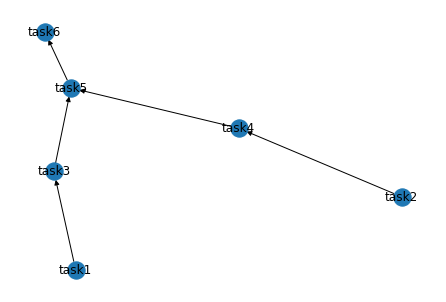

In [10]:
import networkx
from pprint import pprint
import matplotlib.pyplot as plt
from esrftaskgraph import load_graph

pprint(persistent_taskgraph)
runtime_taskgraph = load_graph(persistent_taskgraph)
networkx.draw(runtime_taskgraph.graph, with_labels=True)
plt.show()

### Execute the task graph

In [11]:
# Select scheduler
local_scheduler = True
scheduler = schedulers["dask"]

# Schedulers options
scheduler_options = dict()
if local_scheduler:
    varinfo["root_uri"] = "/tmp/myresults"
    if scheduler is dask_scheduler:
        scheduler_options["scheduler"] = "multithreading"
else:
    varinfo["root_uri"] = "/data/id21/tmp/myresults"
    if scheduler is luigi_scheduler:
        # Run "luigid" on any host
        scheduler_options["scheduler"] = {"local_scheduler": local_scheduler,
                                          "scheduler_host": "localhost",
                                          "scheduler_port":8082,
                                          "workers": 10}
    elif scheduler is dask_scheduler:
        # Run this on any host:
        #  >>> from esrf2dask import local_scheduler
        #  >>> scheduler = local_scheduler(n_workers=5)
        # 
        # Or run this on slurm-access or any slurm node:
        #  >>> from esrf2dask import slurm_scheduler
        #  >>> scheduler = slurm_scheduler(maximum_jobs=5)
        scheduler_options["scheduler"] = {"address": "160.103.228.113:35881"}

# Prepare location for results
prepare_results(clean=True)
%timeit -n 1 -r 1 scheduler(persistent_taskgraph, varinfo, **scheduler_options)

200 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Show the results of each task

In [12]:
tasks = dict()
print(f"Task graph results {repr(runtime_taskgraph)}:")
for node, value in expected_results.items():
    task = runtime_taskgraph.instantiate_task_static(node, tasks=tasks, varinfo=varinfo)
    assert task.done, str(task)
    assert task.output.value == value, str(task)
    print(f"\ntask {repr(node)}:\n Result: {value}\n Storage: {task.output}")

Task graph results taskgraphlib.taskgraphs.acyclic_graph1:

task 'task1':
 Result: {'result': 1}
 Storage: VariableContainer(/tmp/myresults/e68ac464f7cdb8bdb6abe1e24c35fd1068f8668a3ca1608b0349e8603ea4122d.json)

task 'task2':
 Result: {'result': 2}
 Storage: VariableContainer(/tmp/myresults/d7559838beb42e588de454e7e8b0b51ad85f43f919d3c73cc2573f1007014b0c.json)

task 'task3':
 Result: {'result': 4}
 Storage: VariableContainer(/tmp/myresults/c1282221edcec7111c2f0e3947c1c68d20a3963afd7b83032c6fb5fafd4f8653.json)

task 'task4':
 Result: {'result': 6}
 Storage: VariableContainer(/tmp/myresults/17ab1bbb01d195d00982f70879f807c99dfafe7ab45ce8a6f4e5e6450eb3f0a1.json)

task 'task5':
 Result: {'result': 10}
 Storage: VariableContainer(/tmp/myresults/57b7afcfc3b46d3c048ffd3e0cdd925cce128976c83a596f976494eeadcfe32c.json)

task 'task6':
 Result: {'result': 16}
 Storage: VariableContainer(/tmp/myresults/f6be1648129ecd307bd6fe0d5667cbbcc7db9a812fdde71fc1fff95809343164.json)
